In [60]:
pip install pandas requests lxml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [61]:
import os
import re
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [62]:
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
print("ok")

resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
print(resp.status_code)

soup = BeautifulSoup(resp.text, "lxml")
print(soup.title)

ok
200


<title>List of Spotify streaming records - Wikipedia</title>


In [76]:
# Buscar tablas y ver headers
tablas = soup.find_all("table")
print("Tablas encontradas:", len(tablas))

def normalizar(x):
    x = str(x).strip().lower().replace("\xa0", " ")
    x = re.sub(r"\s+", " ", x)
    return x

def headers_text(t):
    ths = t.find_all("th")
    txt = BeautifulSoup(str(ths), "lxml").get_text(" ")
    return normalizar(txt)

for i, t in enumerate(tablas):
    print(f"- tabla {i}: {headers_text(t)[:140]}")


Tablas encontradas: 26
- tabla 0: [ rank , song , artist(s) , streams (billions) , release date , ref. , " blinding lights " , " shape of you " , " sweater weather " , " star
- tabla 1: [ rank , artist , top 100 , top 10 , 3 billion+ streams , 4 billion+ streams , 5 billion+ streams , total songs , lead , feat. , lead , feat
- tabla 2: [ no. , song , artist(s) , streams (billions) , release date , date achieved , days held , ref. , notes , as of 12 february 2026 ]
- tabla 3: []
- tabla 4: [ song [ 116 ] , artist(s) , release date , issue date , wks. , avs. , " starboy " , " shape of you " ‡ , " humble " , " despacito (remix) "
- tabla 5: [ year , artist and song ranking , 1 , 2 , 3 , 4 , 5 ]
- tabla 6: [ rank , song , artist(s) , streams , date published , date achieved , ref. , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 1
- tabla 7: [ rank , song , artist(s) , streams , date published , date achieved , ref. , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14

In [75]:
# Elegir nuestra tabla
indice_tabla = None
for i, t in enumerate(tablas):
    h = headers_text(t)
    if ("rank" in h) and ("song" in h) and ("stream" in h):
        indice_tabla = i
        break
print("indice_tabla detectado:", indice_tabla)

tabla_obj = tablas[indice_tabla]
print("headers (preview):", headers_text(tabla_obj)[:200])

indice_tabla detectado: 0
headers (preview): [ rank , song , artist(s) , streams (billions) , release date , ref. , " blinding lights " , " shape of you " , " sweater weather " , " starboy " , " as it was " , " someone you loved " , " sunflower 


In [74]:
# Extraer tabla (tr/th/td) y armar df_raw
def texto_celda(tag):
    return tag.get_text(" ", strip=True).replace("\xa0", " ")

rows = tabla_obj.find_all("tr")

# headers
headers = []
for tr in rows[:8]:
    ths = tr.find_all("th")
    if ths:
        headers = [texto_celda(th) for th in ths]
        break
    
# data
data = []
for tr in rows:
    if tr.find("td") is None:
        continue

    # tomar celdas en orden: th + td
    celdas = tr.find_all(["th", "td"])
    row = [texto_celda(c) for c in celdas]
    data.append(row)

# Definir max_cols
max_cols = max(len(r) for r in data)

# ajustar headers y filas
if len(headers) < max_cols:
    headers = headers + [f"col_{i}" for i in range(len(headers), max_cols)]
else:
    headers = headers[:max_cols]

data_fix = []
for r in data:
    if len(r) < max_cols:
        r = r + [None] * (max_cols - len(r))
    data_fix.append(r[:max_cols])

df_raw = pd.DataFrame(data_fix, columns=headers)

print("df_raw shape:", df_raw.shape)
print("columnas:", list(df_raw.columns))
df_raw.head(10)

df_raw shape: (100, 6)
columnas: ['Rank', 'Song', 'Artist(s)', 'Streams (billions)', 'Release date', 'Ref.']


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,""" Blinding Lights """,The Weeknd,5.279,29 November 2019,[ 1 ]
1,2,""" Shape of You """,Ed Sheeran,4.771,6 January 2017,[ 2 ]
2,3,""" Sweater Weather """,The Neighbourhood,4.384,3 December 2012,[ 3 ]
3,4,""" Starboy """,The Weeknd and Daft Punk,4.367,21 September 2016,[ 4 ]
4,5,""" As It Was """,Harry Styles,4.250,1 April 2022,[ 5 ]
5,6,""" Someone You Loved """,Lewis Capaldi,4.225,8 November 2018,[ 6 ]
6,7,""" Sunflower """,Post Malone and Swae Lee,4.122,18 October 2018,[ 7 ]
7,8,""" One Dance """,Drake with Wizkid and Kyla,4.040,5 April 2016,[ 8 ]
8,9,""" Perfect """,Ed Sheeran,3.830,3 March 2017,[ 9 ]
9,10,""" Stay """,The Kid LAROI and Justin Bieber,3.799,9 July 2021,[ 10 ]


In [66]:
# Normalizamos todo para facilitar mapeo de columnas
def normalizar(x):
    x = str(x).strip().lower().replace("\xa0", " ")
    return re.sub(r"\s+", " ", x)

cols_norm = {c: normalizar(c) for c in df_raw.columns}

col_rank = col_song = col_artist = col_streams = col_release = col_ref = None
for c, n in cols_norm.items():
    if n == "rank":
        col_rank = c
    elif "song" in n or "title" in n:
        col_song = c
    elif "artist" in n:
        col_artist = c
    elif "stream" in n:
        col_streams = c
    elif ("release" in n and ("date" in n or "year" in n)) or n in ("year", "released"):
        col_release = c
    elif "ref" in n or "reference" in n:
        col_ref = c

# seleccionar columnas
cols_sel = [col_rank, col_song, col_artist, col_streams]
if col_release is not None:
    cols_sel.append(col_release)
else:
    df_raw["Release date"] = np.nan
    col_release = "Release date"
    cols_sel.append(col_release)

if col_ref is not None:
    cols_sel.append(col_ref)
else:
    df_raw["Ref."] = np.nan
    col_ref = "Ref."
    cols_sel.append(col_ref)

df = df_raw[cols_sel].copy()
df.head(10)


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,""" Blinding Lights """,The Weeknd,5.279,29 November 2019,[ 1 ]
1,2,""" Shape of You """,Ed Sheeran,4.771,6 January 2017,[ 2 ]
2,3,""" Sweater Weather """,The Neighbourhood,4.384,3 December 2012,[ 3 ]
3,4,""" Starboy """,The Weeknd and Daft Punk,4.367,21 September 2016,[ 4 ]
4,5,""" As It Was """,Harry Styles,4.250,1 April 2022,[ 5 ]
5,6,""" Someone You Loved """,Lewis Capaldi,4.225,8 November 2018,[ 6 ]
6,7,""" Sunflower """,Post Malone and Swae Lee,4.122,18 October 2018,[ 7 ]
7,8,""" One Dance """,Drake with Wizkid and Kyla,4.040,5 April 2016,[ 8 ]
8,9,""" Perfect """,Ed Sheeran,3.830,3 March 2017,[ 9 ]
9,10,""" Stay """,The Kid LAROI and Justin Bieber,3.799,9 July 2021,[ 10 ]


In [ ]:
# Por ultimo limpiamos la tabla para facilitar analisis
def clean_text(s):
    s = s.astype(str)
    s = s.str.replace("\xa0", " ", regex=False)
    s = s.str.replace(r"\[\s*\d+\s*\]", "", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    s = s.replace({"nan": np.nan, "none": np.nan, "": np.nan})
    return s

# texto
df[col_song] = clean_text(df[col_song])
df[col_artist] = clean_text(df[col_artist])
df[col_ref] = clean_text(df[col_ref])

# rank
df[col_rank] = pd.to_numeric(df[col_rank], errors="coerce").astype("Int64")

# streams (quita comas y convierte)
df[col_streams] = df[col_streams].astype(str).str.replace(",", "", regex=False).str.strip()
df[col_streams] = pd.to_numeric(df[col_streams], errors="coerce")

# release date
df[col_release] = pd.to_datetime(df[col_release], errors="coerce").dt.date

# filas validas
df = df[df[col_rank].notna()].reset_index(drop=True)

# top 100
df_100 = df.sort_values(col_rank).head(100).reset_index(drop=True)

print(df_100.head(10))

   Rank                   Song                        Artist(s)  Streams (billions) Release date Ref.
0     1    " Blinding Lights "                       The Weeknd               5.279   2019-11-29  NaN
1     2       " Shape of You "                       Ed Sheeran               4.771   2017-01-06  NaN
2     3    " Sweater Weather "                The Neighbourhood               4.384   2012-12-03  NaN
3     4            " Starboy "         The Weeknd and Daft Punk               4.367   2016-09-21  NaN
4     5          " As It Was "                     Harry Styles               4.250   2022-04-01  NaN
5     6  " Someone You Loved "                    Lewis Capaldi               4.225   2018-11-08  NaN
6     7          " Sunflower "         Post Malone and Swae Lee               4.122   2018-10-18  NaN
7     8          " One Dance "       Drake with Wizkid and Kyla               4.040   2016-04-05  NaN
8     9            " Perfect "                       Ed Sheeran               3.83

Visualizacion de datos

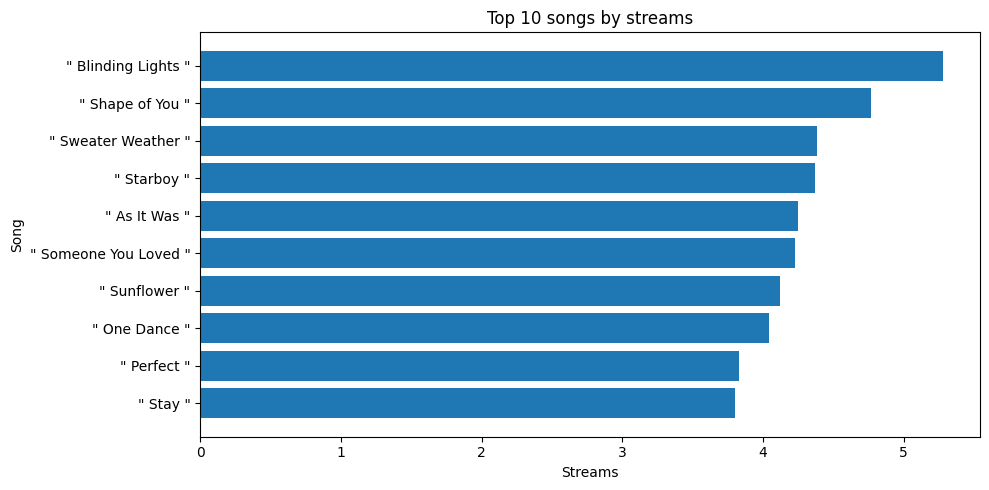

In [68]:
# Top 10 canciones por Streams (barra horizontal)
top10 = df_100.sort_values(col_streams, ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(top10[col_song], top10[col_streams])
plt.gca().invert_yaxis()
plt.title("Top 10 songs by streams")
plt.xlabel("Streams")
plt.ylabel("Song")
plt.tight_layout()
plt.show()


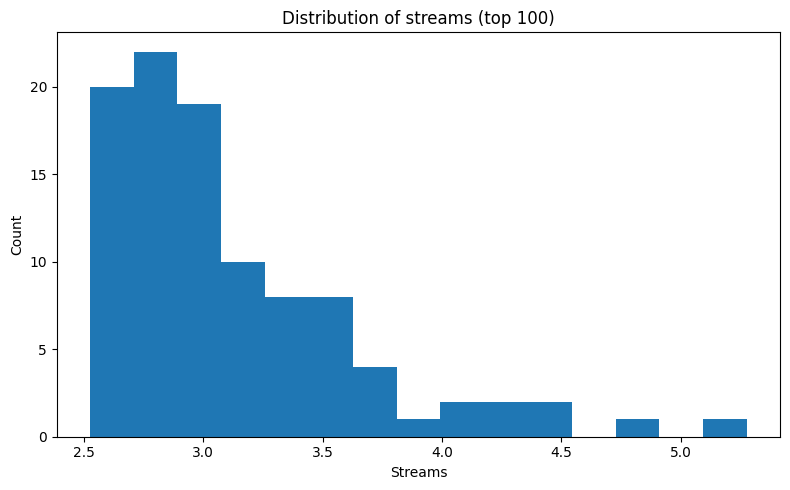

In [69]:
# Distribucion de Streams (histograma)
plt.figure(figsize=(8,5))
plt.hist(df_100[col_streams].dropna(), bins=15)
plt.title("Distribution of streams (top 100)")
plt.xlabel("Streams")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


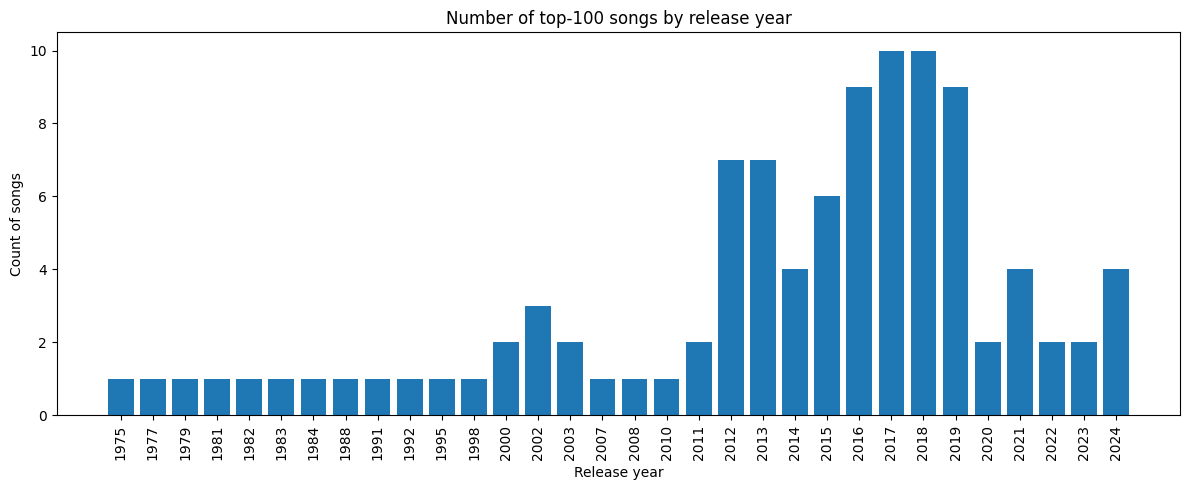

In [70]:
# Canciones por ano de lanzamiento (barras)
years = pd.to_datetime(df_100[col_release], errors="coerce").dt.year
counts = years.value_counts().sort_index()

plt.figure(figsize=(12,5))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Number of top-100 songs by release year")
plt.xlabel("Release year")
plt.ylabel("Count of songs")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Almacenamiento de los datos en sqlite

In [86]:
DB_PATH = "spotify_top100.db"
TABLE = "most_streamed_songs"

tmp = df_100[[col_rank, col_song, col_artist, col_streams, col_release, col_ref]].copy()
tmp.columns = ["rank", "song", "artists", "streams", "release_date", "ref"]

tmp["rank"] = pd.to_numeric(tmp["rank"], errors="coerce").astype("int64").astype(int)
tmp["streams"] = pd.to_numeric(tmp["streams"], errors="coerce").astype(float)

tmp["release_date"] = pd.to_datetime(tmp["release_date"], errors="coerce").dt.strftime("%Y-%m-%d")

tmp["ref"] = tmp["ref"].fillna("").astype(str)

conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

cur.execute(f"DROP TABLE IF EXISTS {TABLE}")
cur.execute(f"""
CREATE TABLE {TABLE} (
    rank INTEGER,
    song TEXT,
    artists TEXT,
    streams REAL,
    release_date TEXT,
    ref TEXT)""")

filas = [tuple(r) for r in tmp.to_numpy()]
cur.executemany(
    f"INSERT INTO {TABLE} (rank, song, artists, streams, release_date, ref) VALUES (?, ?, ?, ?, ?, ?)",
    filas)
conn.commit()

cur.execute(f"SELECT rank, typeof(rank) FROM {TABLE} ORDER BY rank ASC LIMIT 5")
print("check typeof(rank):", cur.fetchall())

df_sql = pd.read_sql_query(f"SELECT * FROM {TABLE} ORDER BY rank ASC LIMIT 10", conn)
conn.close()

df_sql


check typeof(rank): [(1, 'integer'), (2, 'integer'), (3, 'integer'), (4, 'integer'), (5, 'integer')]


,rank,song,artists,streams,release_date,ref
0,1,""" Blinding Lights """,The Weeknd,5.279,2019-11-29,
1,2,""" Shape of You """,Ed Sheeran,4.771,2017-01-06,
2,3,""" Sweater Weather """,The Neighbourhood,4.384,2012-12-03,
3,4,""" Starboy """,The Weeknd and Daft Punk,4.367,2016-09-21,
4,5,""" As It Was """,Harry Styles,4.250,2022-04-01,
5,6,""" Someone You Loved """,Lewis Capaldi,4.225,2018-11-08,
6,7,""" Sunflower """,Post Malone and Swae Lee,4.122,2018-10-18,
7,8,""" One Dance """,Drake with Wizkid and Kyla,4.040,2016-04-05,
8,9,""" Perfect """,Ed Sheeran,3.830,2017-03-03,
9,10,""" Stay """,The Kid LAROI and Justin Bieber,3.799,2021-07-09,


In [85]:
df_sql = pd.read_sql_query(f"SELECT * FROM {TABLE} ORDER BY rank ASC", sqlite3.connect(DB_PATH))
df_sql.head(10)


,rank,song,artists,streams,release_date,ref
0,1,""" Blinding Lights """,The Weeknd,5.279,2019-11-29,
1,2,""" Shape of You """,Ed Sheeran,4.771,2017-01-06,
2,3,""" Sweater Weather """,The Neighbourhood,4.384,2012-12-03,
3,4,""" Starboy """,The Weeknd and Daft Punk,4.367,2016-09-21,
4,5,""" As It Was """,Harry Styles,4.250,2022-04-01,
5,6,""" Someone You Loved """,Lewis Capaldi,4.225,2018-11-08,
6,7,""" Sunflower """,Post Malone and Swae Lee,4.122,2018-10-18,
7,8,""" One Dance """,Drake with Wizkid and Kyla,4.040,2016-04-05,
8,9,""" Perfect """,Ed Sheeran,3.830,2017-03-03,
9,10,""" Stay """,The Kid LAROI and Justin Bieber,3.799,2021-07-09,
